# Laboratorio 3
## Malware Detection
Universidad del Valle de Guatemala<br>
Security Data Science<br>
Sección 10<br>
Pablo Andrés Zamora Vásquez - 21780<br>
Diego Andrés Morales Aquino - 21762<br>
<br><br>
<hr>

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Modelo 1: ML

### Exploración de datos

In [19]:
# Cargar el dataset
file_path = "MalBehavD-V1-dataset.csv"
df = pd.read_csv(file_path)

# Mostrar el balance de clases en la columna objetivo
class_distribution = df['labels'].value_counts()
print(class_distribution)

labels
0    1285
1    1285
Name: count, dtype: int64


In [20]:
# Mostrar algunas filas de las columnas numéricas para ver cómo están representadas las secuencias
df_numeric_preview = df.iloc[:, 2:20].head()  # Tomar algunas columnas numéricas para inspección
df_numeric_preview

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,LdrUnloadDll,CoUninitialize,NtQueryKey,NtDuplicateObject,GetShortPathNameW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtClose,GetFileVersionInfoSizeW,NtOpenProcess,GetFileAttributesW,RegQueryValueExW,NtMapViewOfSection,RtlAddVectoredExceptionHandler,GetFileSize,RegOpenKeyExW,SetErrorMode
1,NtOpenMutant,GetForegroundWindow,NtQueryKey,DrawTextExW,NtSetInformationFile,RegQueryValueExA,LdrGetProcedureAddress,CoUninitialize,NtQueryValueKey,RegCloseKey,RegQueryValueExW,NtFreeVirtualMemory,GetSystemMetrics,CreateActCtxW,RegOpenKeyExW,NtReadFile,CreateDirectoryW,NtWriteFile
2,GetForegroundWindow,DrawTextExW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtQueryValueKey,RegCloseKey,GetFileAttributesW,RegQueryValueExW,NtMapViewOfSection,GetSystemMetrics,RegOpenKeyExW,NtAllocateVirtualMemory,NtWriteFile,LdrGetDllHandle,NtFreeVirtualMemory,FindResourceExA,NtOpenFile
3,NtQueryValueKey,LdrUnloadDll,GlobalMemoryStatus,WriteConsoleA,NtOpenKey,LdrGetProcedureAddress,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,LdrGetDllHandle,GetFileType,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LdrUnloadDll,GetSystemTimeAsFileTime,NtOpenKey,WSAStartup,SetUnhandledExceptionFilter,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,NtQueryAttributesFile,LdrGetDllHandle,NtQueryValueKey,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Verificación de valores nulos
print("\nValores nulos por columna:")
print(df.isnull().sum())

# Verificación de valores duplicados
print(f"\nNúmero de registros duplicados: {df.duplicated().sum()}")


Valores nulos por columna:
sha256             0
labels             0
0                  0
1                  0
2                  6
                ... 
Unnamed: 172    2569
Unnamed: 173    2569
Unnamed: 174    2569
Unnamed: 175    2569
Unnamed: 176    2569
Length: 177, dtype: int64

Número de registros duplicados: 16


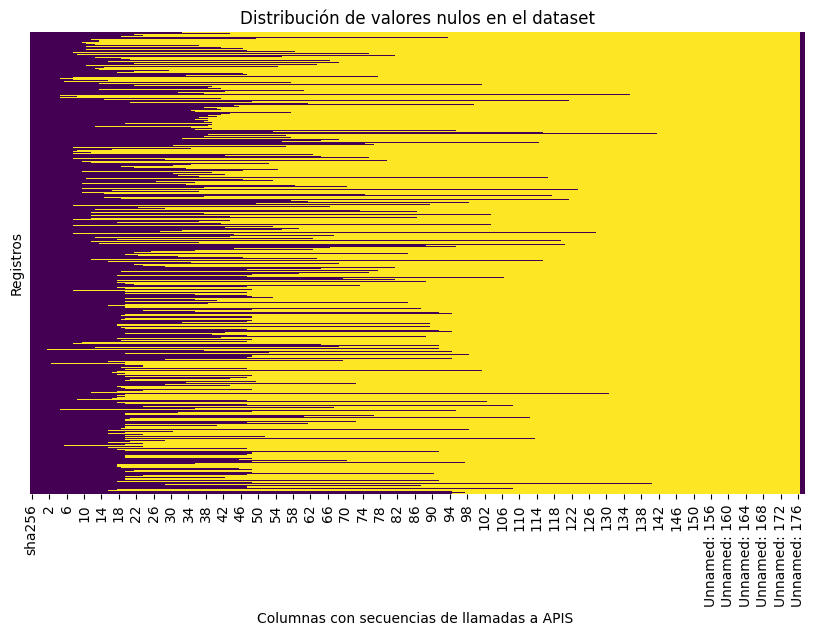

In [28]:
#  Graficar la distribución de valores nulos
null_mask = df.isnull()

plt.figure(figsize=(10, 6))
sns.heatmap(null_mask, cmap='viridis', cbar=False, yticklabels=False)
plt.xlabel("Columnas con secuencias de llamadas a APIS ")
plt.ylabel("Registros")
plt.title("Distribución de valores nulos en el dataset")
plt.show()


Tal y como se observa en el gráfico de distribución de valores nulos, estos corresponden a que hay secuencias a llamadas más cortas que otras. Por lo que no representan un problema para el análisis de las secuencias, solo deben de ignorarse.

### Preprocesamiento

Para cada registro, se concatenarán las columnas con las llamadas a las APIs en una sola secuencia. Luego, cada secuencia se convertirán a vectores numéricos usando TF-IDF:

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Concatenar todas las columnas numéricas en una sola secuencia por fila
df["api_sequence"] = df.iloc[:, 2:].astype(str).apply(lambda row: ' '.join(row.dropna()), axis=1)

# Aplicar TF-IDF para vectorizar las secuencias
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df["api_sequence"])

# Mostrar la dimensión del nuevo conjunto de características
X_tfidf.shape

(2570, 292)

### Implementación

Se implementará un modelo de Random Forest para clasificar cada secuencia de llamadas a APIs como maligna o benigna:

In [23]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Definir las etiquetas de la clasificación
y = df["labels"].astype(int)

# Definir el modelo de Random Forest con 100 árboles
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Dividir el conjunto de datos en 70% entrenamiento y 30% pruebas
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.30, random_state=42, stratify=y)

# Realizar validación cruzada en el conjunto de entrenamiento
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=10, scoring="accuracy")

# Entrenar el modelo en todo el conjunto de entrenamiento
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Validación

In [24]:
# Evaluar en el conjunto de prueba
y_pred_test = rf_model.predict(X_test)

# Calcular métricas en el conjunto de prueba
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_pred_test)

# Mostrar los resultados
print('Cross-validation Accuracy: ', cv_scores.mean())
print('Accuracy: ', accuracy_test)
print('Precision: ', precision_test)
print('Recall: ', recall_test)
print('ROC AUC: ', roc_auc_test)

Cross-validation Accuracy:  0.963314711359404
Accuracy:  0.9649805447470817
Precision:  0.9890710382513661
Recall:  0.9402597402597402
ROC AUC:  0.964948522979611


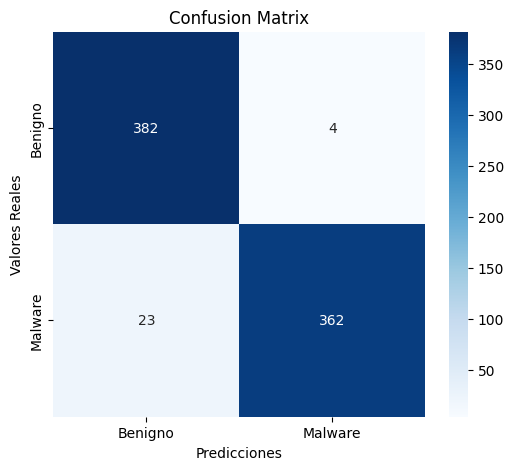

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = rf_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benigno', 'Malware'], yticklabels=['Benigno', 'Malware'])
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Confusion Matrix")
plt.show()



El modelo de clasificación de malware con Random Forest muestra un muy buen desempeño, con una accuracy de 0.96, es decir que logró identificar el malware de forma adecuada en la mayoría de predicciones. Se utilizó validación cruzada con 10 particiones (folds) para evitar overfitting, lo que resultó en una media de accuracy de 0.963 en el entrenamiento. Este resultado refleja la estabilidad del modelo con diferentes subconjuntos de datos.

Por otro lado, la precisión de 0.98 sugiere que el modelo identifica correctamente el malware en casi todos los casos, minimizando los falsos positivos. En la matriz de confusión se observa que tan solo 4 archivos fueron clasificados incorrectamente como malware. Además, el recall de 0.94, aunque no tan alto como la precisión, indica que el modelo hace un buen trabajo evitando falsos negativos, reconociendo el 94% de los casos de phishing del total de enlaces malignos.  Esto se observa en la matriz de confusión, con tan solo 23 predicciones incorrectamente clasificadas como ejecutables benignos.


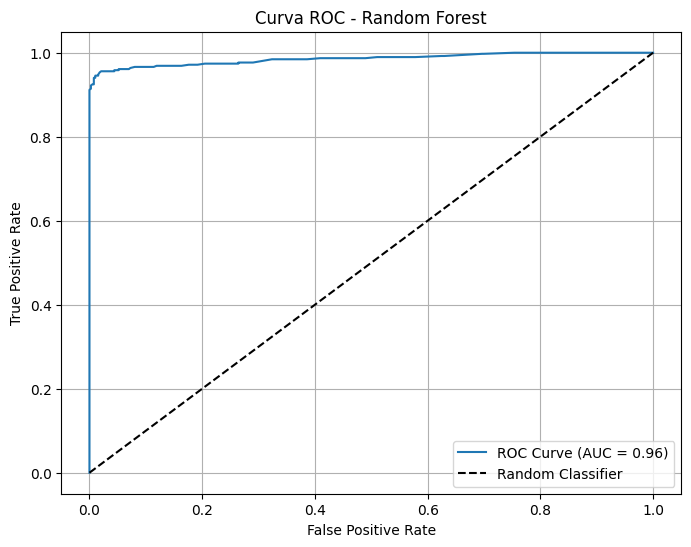

In [26]:
from sklearn.metrics import roc_curve

# Obtener la curva ROC
fpr, tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_test:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Random Forest")
plt.legend()
plt.grid()
plt.show()

La curva ROC muestra que el modelo tiene un muy buen desempeño, con una forma bastante pronunciada que se mantiene cerca del valor máximo, lo cual indica que el modelo tiene una alta capacidad de discriminación. Además, posee un Área Bajo la Curva (AUC) de 96.50%, lo que indica que en el 96.5% de los casos, el modelo asignará una puntuación más alta al malware que a archivos benignos en la clasificación de malware.